# ホールドアウト検証

In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import os
import h5py
import joblib #並列処理のためのライブラリ
import shutil
from tqdm import tqdm # for文の進捗をプログレスバーで可視化する
import matplotlib.pyplot as plt
import glob
import wave

# モデルの再現性確保
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(1)
tf.random.set_seed(1)

訓練データのパスを定義

In [2]:
datas_dir = '../data/wav/'
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
# testdata,valdataを除く8日分のデータを前半と後半に分ける
firsthalf_traindata = [datas_dir+'210919_0031.wav', datas_dir+'210923_0034.wav', datas_dir+'210924_0035.wav', datas_dir+'210925_0036.wav']
latterhalf_traindata = [datas_dir+'210926_0037.wav', datas_dir+'210927_0038.wav', datas_dir+'210928_0039.wav', datas_dir+'210929_0040.wav']

all_traindata = firsthalf_traindata+latterhalf_traindata # テストデータ,valdataを除く8日分のデータのパス
each_data_path_group = (firsthalf_traindata, latterhalf_traindata)

前半，後半それぞれのラベルデータ(異常ラベル追加前)の配列をタプルでまとめる

In [3]:
label_data_dir = '../data/original_label/'

label_df_firsthalf_traindata = [] # 前半データの正解ラベルのデータフレームを格納したリスト
for i in firsthalf_traindata:
    label_data_name = i.split('/')[-1].replace('.wav', '.csv') 
    label_data_file = label_data_dir+label_data_name
    label_data_df=pd.read_csv(label_data_file, skiprows=4, usecols=[1], header=None) 
    label_array = label_data_df.iloc[:, 0].values
    label_df_firsthalf_traindata.append(label_array)

label_df_latterhalf_traindata = [] # 後半データの正解ラベルのデータフレームを格納したリスト
for i in latterhalf_traindata:
    label_data_name = i.split('/')[-1].replace('.wav', '.csv') 
    label_data_file = label_data_dir+label_data_name
    label_data_df=pd.read_csv(label_data_file, skiprows=4, usecols=[1], header=None)
    label_array = label_data_df.iloc[:, 0].values
    label_df_latterhalf_traindata.append(label_array)
    
each_data_original_array_group = (label_df_firsthalf_traindata, label_df_latterhalf_traindata)

閾値を求める際に使用するデータのパス

In [4]:
threshold_data_path = '../data/threshold/NormalandAnormSound.hdf5'

各日のメルスペクトログラムが保存されたhdfファイルのパス

In [5]:
eachday_hdf = '../data/eachday/eachday.hdf5'

メルスペクトログラムのパラメータ

In [6]:
sr = 16000 # サンプリング周波数
duration = 1 # メルスペクトログラムの時間幅[s]
melparams = {'sr':sr, 'n_mels':128, 'fmin':0, 'fmax':sr/2} # メルスペクトログラムのパラメータ

データ拡張用のオブジェクト

In [7]:
# データ拡張のためのクラスをimport 
from audio_DA import Multiple, ResampleWaveform, GaussianNoiseSNR, PinkNoiseSNR, PitchShift, TimeShift, VolumeShift

# 複数の音声処理の関数
# なんの音声処理をするかを決める
transform = Multiple([
    GaussianNoiseSNR(min_snr=15, max_snr=30),
    PinkNoiseSNR(min_snr=8, max_snr=30),
    PitchShift(max_steps=2, sr=sr),
    TimeShift(sr=sr),
    VolumeShift(mode="cosine")
])

In [8]:
from AutoEncoder import AutoEncoder

SemiSLAutoEncoder = AutoEncoder(
    each_data_path_group=each_data_path_group, each_data_original_array_group=each_data_original_array_group, 
    threshold_data_path=threshold_data_path, eachday_hdf=eachday_hdf, transform=transform, 
    sr=sr, duration=duration, melparams=melparams)

## 学習フェーズ

npy_output: ./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 445.66it/s]


./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/にnpyファイルを保存しました．
hdf_output: ./data_output/hdf5/firsthalf_NormalSound.hdf5
全データ数: 646452
訓練データ数： 581806
valデータ数： 64646


100%|█████████████████████████████████████████████████████████████████████████| 646452/646452 [17:59<00:00, 599.00it/s]


train_base: (128, 32)
val_base: (128, 32)
train_shape (581806, 128, 32, 3)
val_shape (64646, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 64646/64646 [03:07<00:00, 344.40it/s]


./data_output/hdf5/firsthalf_NormalSound.hdf5にhdfファイルを保存しました
Model: "firsthalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_____________________________________________

Epoch 58/60
285/285 [==============================] - 54s 191ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 59/60
285/285 [==============================] - 56s 197ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 60/60
285/285 [==============================] - 56s 195ms/step - loss: 0.0015 - val_loss: 0.0015
trained_model_save_path: ./data_output/trainedmodel/firsthalf/0_autoencoder.hd5
[./data_output/trainedmodel/firsthalf/0_autoencoder.hd5]にモデルを保存しました．
npy_output: ./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4000.29it/s]


./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/にnpyファイルを保存しました．
hdf_output: ./data_output/hdf5/latterhalf_NormalSound.hdf5
全データ数: 471956
訓練データ数： 424760
valデータ数： 47196


100%|█████████████████████████████████████████████████████████████████████████| 471956/471956 [12:48<00:00, 614.40it/s]


train_base: (128, 32)
val_base: (128, 32)
train_shape (424760, 128, 32, 3)
val_shape (47196, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 47196/47196 [02:03<00:00, 383.61it/s]


./data_output/hdf5/latterhalf_NormalSound.hdf5にhdfファイルを保存しました
Model: "latterhalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
___________________________________________

Epoch 58/60
208/208 [==============================] - 37s 178ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 59/60
208/208 [==============================] - 38s 182ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 60/60
208/208 [==============================] - 39s 188ms/step - loss: 0.0014 - val_loss: 0.0014
trained_model_save_path: ./data_output/trainedmodel/latterhalf/0_autoencoder.hd5
[./data_output/trainedmodel/latterhalf/0_autoencoder.hd5]にモデルを保存しました．
datas:['../data/wav/210919_0031.wav', '../data/wav/210923_0034.wav', '../data/wav/210924_0035.wav', '../data/wav/210925_0036.wav']
(i-1)*(-1)が0:前半データの正常音で学習させたモデル
(i-1)*(-1)が1:後半データの正常音で学習させたモデル
(i-1)*(-1):1
Model: "latterhalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)             

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0021065035834908485
label: 210919_0031
dataset[210919_0031_files].shape:(90304, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90304/90304 [00:11<00:00, 8151.65it/s]


data_value.shape: (90304, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 353/353 [00:11<00:00, 29.66it/s]


decoded_imgs.shape: (90304, 128, 32, 3)
data.shape: (90304, 128, 32, 3)
anomary_scores.shape: (90304,)
./data_output/label_updated/210919_0031.csvが既に存在するため削除します
./data_output/label_updated/210919_0031.csv削除完了
label: 210923_0034
dataset[210923_0034_files].shape:(75928, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 75928/75928 [00:09<00:00, 7964.79it/s]


data_value.shape: (75928, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [00:10<00:00, 28.86it/s]


decoded_imgs.shape: (75928, 128, 32, 3)
data.shape: (75928, 128, 32, 3)
anomary_scores.shape: (75928,)
./data_output/label_updated/210923_0034.csvが既に存在するため削除します
./data_output/label_updated/210923_0034.csv削除完了
label: 210924_0035
dataset[210924_0035_files].shape:(88187, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 88187/88187 [00:11<00:00, 7837.52it/s]


data_value.shape: (88187, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:11<00:00, 30.07it/s]


decoded_imgs.shape: (88187, 128, 32, 3)
data.shape: (88187, 128, 32, 3)
anomary_scores.shape: (88187,)
./data_output/label_updated/210924_0035.csvが既に存在するため削除します
./data_output/label_updated/210924_0035.csv削除完了
label: 210925_0036
dataset[210925_0036_files].shape:(88295, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 88295/88295 [00:11<00:00, 7906.69it/s]


data_value.shape: (88295, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:11<00:00, 29.36it/s]


decoded_imgs.shape: (88295, 128, 32, 3)
data.shape: (88295, 128, 32, 3)
anomary_scores.shape: (88295,)
./data_output/label_updated/210925_0036.csvが既に存在するため削除します
./data_output/label_updated/210925_0036.csv削除完了
datas:['../data/wav/210926_0037.wav', '../data/wav/210927_0038.wav', '../data/wav/210928_0039.wav', '../data/wav/210929_0040.wav']
(i-1)*(-1)が0:前半データの正常音で学習させたモデル
(i-1)*(-1)が1:後半データの正常音で学習させたモデル
(i-1)*(-1):0
Model: "firsthalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)  

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.51it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.002043452113866806
label: 210926_0037
dataset[210926_0037_files].shape:(74647, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 74647/74647 [00:09<00:00, 7981.07it/s]


data_value.shape: (74647, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [00:10<00:00, 28.86it/s]


decoded_imgs.shape: (74647, 128, 32, 3)
data.shape: (74647, 128, 32, 3)
anomary_scores.shape: (74647,)
./data_output/label_updated/210926_0037.csvが既に存在するため削除します
./data_output/label_updated/210926_0037.csv削除完了
label: 210927_0038
dataset[210927_0038_files].shape:(85482, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 85482/85482 [00:10<00:00, 8024.19it/s]


data_value.shape: (85482, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [00:11<00:00, 29.64it/s]


decoded_imgs.shape: (85482, 128, 32, 3)
data.shape: (85482, 128, 32, 3)
anomary_scores.shape: (85482,)
./data_output/label_updated/210927_0038.csvが既に存在するため削除します
./data_output/label_updated/210927_0038.csv削除完了
label: 210928_0039
dataset[210928_0039_files].shape:(85104, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 85104/85104 [00:10<00:00, 8009.11it/s]


data_value.shape: (85104, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.19it/s]


decoded_imgs.shape: (85104, 128, 32, 3)
data.shape: (85104, 128, 32, 3)
anomary_scores.shape: (85104,)
./data_output/label_updated/210928_0039.csvが既に存在するため削除します
./data_output/label_updated/210928_0039.csv削除完了
label: 210929_0040
dataset[210929_0040_files].shape:(83860, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 83860/83860 [00:10<00:00, 7950.21it/s]


data_value.shape: (83860, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 328/328 [00:10<00:00, 30.01it/s]


decoded_imgs.shape: (83860, 128, 32, 3)
data.shape: (83860, 128, 32, 3)
anomary_scores.shape: (83860,)
./data_output/label_updated/210929_0040.csvが既に存在するため削除します
./data_output/label_updated/210929_0040.csv削除完了
npy_output: ./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/
./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/が既に存在するため削除します
./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/削除完了


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


./data_output/npy_files/正常音/firsthalf_1sec正常音16000hz/にnpyファイルを保存しました．
hdf_output: ./data_output/hdf5/firsthalf_NormalSound.hdf5
./data_output/hdf5/firsthalf_NormalSound.hdf5が既に存在するため削除します
./data_output/hdf5/firsthalf_NormalSound.hdf5削除完了
全データ数: 644628
訓練データ数： 580165
valデータ数： 64463


100%|█████████████████████████████████████████████████████████████████████████| 644628/644628 [18:36<00:00, 577.15it/s]


train_base: (128, 32)
val_base: (128, 32)
train_shape (580165, 128, 32, 3)
val_shape (64463, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 64463/64463 [02:52<00:00, 373.36it/s]


./data_output/hdf5/firsthalf_NormalSound.hdf5にhdfファイルを保存しました
Model: "firsthalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_____________________________________________

Epoch 58/60
284/284 [==============================] - 58s 203ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 59/60
284/284 [==============================] - 57s 201ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 60/60
284/284 [==============================] - 58s 203ms/step - loss: 0.0014 - val_loss: 0.0014
trained_model_save_path: ./data_output/trainedmodel/firsthalf/1_autoencoder.hd5
[./data_output/trainedmodel/firsthalf/1_autoencoder.hd5]にモデルを保存しました．
npy_output: ./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/
./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/が既に存在するため削除します
./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/削除完了


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4004.11it/s]


./data_output/npy_files/正常音/latterhalf_1sec正常音16000hz/にnpyファイルを保存しました．
hdf_output: ./data_output/hdf5/latterhalf_NormalSound.hdf5
./data_output/hdf5/latterhalf_NormalSound.hdf5が既に存在するため削除します
./data_output/hdf5/latterhalf_NormalSound.hdf5削除完了
全データ数: 470900
訓練データ数： 423810
valデータ数： 47090


100%|█████████████████████████████████████████████████████████████████████████| 470900/470900 [13:33<00:00, 578.93it/s]


train_base: (128, 32)
val_base: (128, 32)
train_shape (423810, 128, 32, 3)
val_shape (47090, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 47090/47090 [01:46<00:00, 443.99it/s]


./data_output/hdf5/latterhalf_NormalSound.hdf5にhdfファイルを保存しました
Model: "latterhalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
___________________________________________

Epoch 58/60
207/207 [==============================] - 41s 196ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 59/60
207/207 [==============================] - 41s 198ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 60/60
207/207 [==============================] - 93s 444ms/step - loss: 0.0014 - val_loss: 0.0014
trained_model_save_path: ./data_output/trainedmodel/latterhalf/1_autoencoder.hd5
[./data_output/trainedmodel/latterhalf/1_autoencoder.hd5]にモデルを保存しました．
datas:['../data/wav/210919_0031.wav', '../data/wav/210923_0034.wav', '../data/wav/210924_0035.wav', '../data/wav/210925_0036.wav']
(i-1)*(-1)が0:前半データの正常音で学習させたモデル
(i-1)*(-1)が1:後半データの正常音で学習させたモデル
(i-1)*(-1):1
Model: "latterhalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)             

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.51it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.001960507594048977
label: 210919_0031
dataset[210919_0031_files].shape:(90304, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90304/90304 [00:12<00:00, 7433.61it/s]


data_value.shape: (90304, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 353/353 [00:09<00:00, 38.14it/s]


decoded_imgs.shape: (90304, 128, 32, 3)
data.shape: (90304, 128, 32, 3)
anomary_scores.shape: (90304,)
label: 210923_0034
dataset[210923_0034_files].shape:(75928, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 75928/75928 [00:09<00:00, 7767.47it/s]


data_value.shape: (75928, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [00:07<00:00, 37.67it/s]


decoded_imgs.shape: (75928, 128, 32, 3)
data.shape: (75928, 128, 32, 3)
anomary_scores.shape: (75928,)
label: 210924_0035
dataset[210924_0035_files].shape:(88187, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 88187/88187 [00:11<00:00, 7779.45it/s]


data_value.shape: (88187, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:08<00:00, 38.99it/s]


decoded_imgs.shape: (88187, 128, 32, 3)
data.shape: (88187, 128, 32, 3)
anomary_scores.shape: (88187,)
label: 210925_0036
dataset[210925_0036_files].shape:(88295, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 88295/88295 [00:11<00:00, 7773.05it/s]


data_value.shape: (88295, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:08<00:00, 39.43it/s]


decoded_imgs.shape: (88295, 128, 32, 3)
data.shape: (88295, 128, 32, 3)
anomary_scores.shape: (88295,)
datas:['../data/wav/210926_0037.wav', '../data/wav/210927_0038.wav', '../data/wav/210928_0039.wav', '../data/wav/210929_0040.wav']
(i-1)*(-1)が0:前半データの正常音で学習させたモデル
(i-1)*(-1)が1:後半データの正常音で学習させたモデル
(i-1)*(-1):0
Model: "firsthalf_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
___________________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.11it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0019460428738966584
label: 210926_0037
dataset[210926_0037_files].shape:(74647, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 74647/74647 [00:09<00:00, 7680.33it/s]


data_value.shape: (74647, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [00:07<00:00, 38.16it/s]


decoded_imgs.shape: (74647, 128, 32, 3)
data.shape: (74647, 128, 32, 3)
anomary_scores.shape: (74647,)
label: 210927_0038
dataset[210927_0038_files].shape:(85482, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 85482/85482 [00:11<00:00, 7689.93it/s]


data_value.shape: (85482, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [00:08<00:00, 38.26it/s]


decoded_imgs.shape: (85482, 128, 32, 3)
data.shape: (85482, 128, 32, 3)
anomary_scores.shape: (85482,)
label: 210928_0039
dataset[210928_0039_files].shape:(85104, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 85104/85104 [00:11<00:00, 7527.74it/s]


data_value.shape: (85104, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:09<00:00, 34.13it/s]


decoded_imgs.shape: (85104, 128, 32, 3)
data.shape: (85104, 128, 32, 3)
anomary_scores.shape: (85104,)
label: 210929_0040
dataset[210929_0040_files].shape:(83860, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 83860/83860 [00:11<00:00, 7585.65it/s]


data_value.shape: (83860, 128, 32, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 328/328 [00:08<00:00, 38.64it/s]


decoded_imgs.shape: (83860, 128, 32, 3)
data.shape: (83860, 128, 32, 3)
anomary_scores.shape: (83860,)


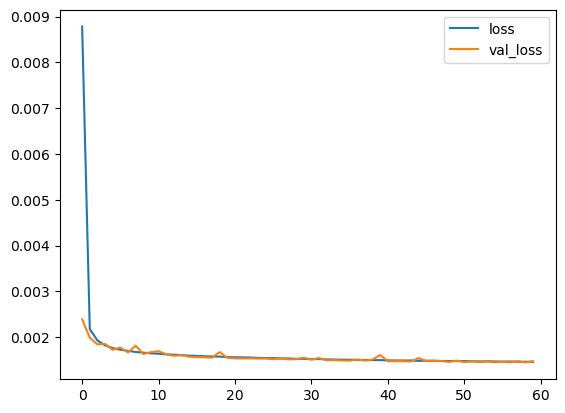

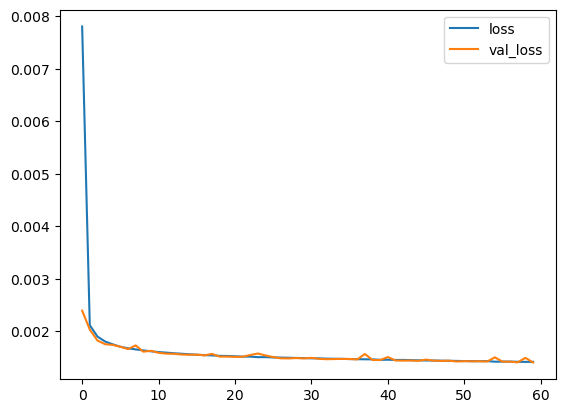

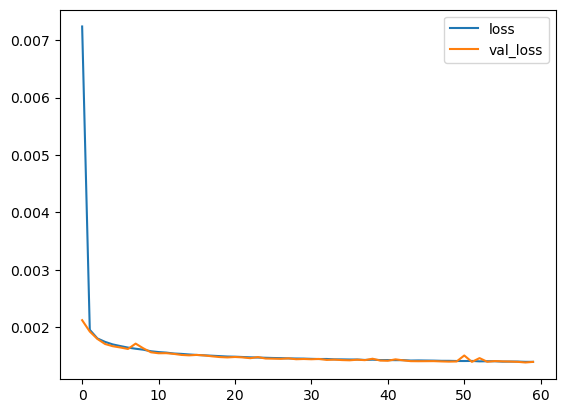

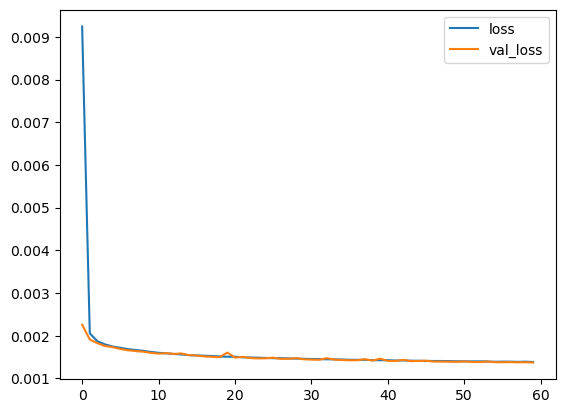

In [9]:
SemiSLAutoEncoder.co_fit(2, 2048, 60)

./data_output/label_final/210919_0031.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
431980,0
431981,0
431982,0
431983,0


./data_output/label_final/210923_0034.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
377985,0
377986,0
377987,0
377988,0


./data_output/label_final/210924_0035.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
431975,0
431976,0
431977,0
431978,0


./data_output/label_final/210925_0036.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
431980,0
431981,0
431982,0
431983,0


./data_output/label_final/210926_0037.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
359980,0
359981,0
359982,0
359983,0


./data_output/label_final/210927_0038.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
413980,0
413981,0
413982,0
413983,0


./data_output/label_final/210928_0039.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
413980,0
413981,0
413982,0
413983,0


./data_output/label_final/210929_0040.csv


,1
0,0
1,0
2,0
3,0
4,0
...,...
413980,0
413981,0
413982,0
413983,0


npy_output: ./data_output/npy_files/全訓練データ/


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7843.49it/s]


./data_output/npy_files/全訓練データ/にnpyファイルを保存しました．
hdf_output: ./data_output/hdf5/alltraindata_NormalSound.hdf5
全データ数: 1115108
訓練データ数： 1003597
valデータ数： 111511


100%|███████████████████████████████████████████████████████████████████████| 1115108/1115108 [34:19<00:00, 541.48it/s]


train_base: (128, 32)
val_base: (128, 32)
train_shape (1003597, 128, 32, 3)
val_shape (111511, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 111511/111511 [05:40<00:00, 327.41it/s]


訓練データ平均値：-40.23991012573242
訓練データ標準偏差：11.048879623413086
./data_output/hdf5/alltraindata_NormalSound.hdf5にhdfファイルを保存しました
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)   

491/491 [==============================] - 98s 198ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 57/100
491/491 [==============================] - 95s 194ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 58/100
491/491 [==============================] - 104s 212ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 59/100
491/491 [==============================] - 97s 197ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 60/100
491/491 [==============================] - 97s 197ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 61/100
491/491 [==============================] - 98s 199ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 62/100
491/491 [==============================] - 96s 194ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 63/100
491/491 [==============================] - 96s 196ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 64/100
491/491 [==============================] - 97s 197ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 65/100
491/491 [==============================] - 96s 196ms/s

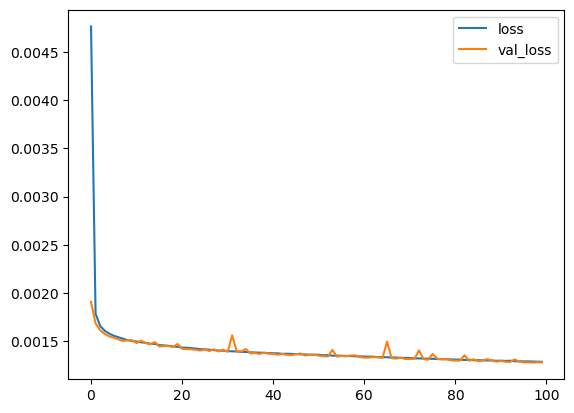

In [10]:
SemiSLAutoEncoder.all_fit(2048, 100)

## 推論フェーズ

In [11]:
# duration単位の異常度の結果を0.2秒単位に変換する
def result_to_200ms(result, duration):
    import numpy as np
    total_time = len(result)*duration
    step =int(duration/0.2)
    result_200ms = np.zeros(int(total_time/0.2))
    for i in range(len(result)):
        if i<len(result)-1:
            result_200ms[i*step:(i+1)*step] = result[i]
        else:
            result_200ms[i*step:] = result[i]

    return result_200ms

'''
0.２秒単位の配列を1秒単位の配列に変換する
'''
def label_to_sec(label):
    import numpy as np
    unit_sec = int(1/0.2)
#     print(type(unit_sec))
#     print(unit_sec)
    label_sec_array = label[unit_sec::unit_sec]

    return label_sec_array

In [12]:
# 適合率・再現率・F値の可視化
def fig_pre_re_f(list, pre,re,fscore):
    fig, ax = plt.subplots(facecolor="w")
    ax.set_xlabel("Threshold")
    ax.grid()

    ax.plot(list, pre, label="Precision", marker='o')
    ax.plot(list, re, label="Recall", marker='s')
    ax.plot(list, fscore, label="fscore", marker='v')
    ax.legend()
# F値の可視化
def fig_fscore(list,fscores):
    fig, ax = plt.subplots(facecolor="w")
    ax.set_xlabel("Threshold")
    ax.grid()
    ax.plot(list, fscores, label="fscore")
    ax.legend()
# 適合率の可視化
def fig_precision(list,pre):
    fig, ax = plt.subplots(facecolor="w")
    ax.set_xlabel("Threshold")
    ax.grid()
    ax.plot(list, pre, label="Precision")
    ax.legend()
# 再現率の可視化
def fig_recall(list,re):
    fig, ax = plt.subplots(facecolor="w")
    ax.set_xlabel("Threshold")
    ax.grid()
    ax.plot(list, re, label="Recall")
    ax.legend()
    
# PR曲線
def fig_PR(test, score, bins):
    """
    test:一列目に正解ラベルが記入されたデータフレーム
    score：異常度
    bins：PR曲線の閾値の数(計算時に切り捨てをしているので正確にこの数にはならない)
    """
    from sklearn.metrics import precision_recall_curve, auc
    
    test_array = test.iloc[:, 0].values
    print('test_array:', test_array)
    print('test:', test)
    print(np.bincount(test_array))  
    test_array = np.where(test_array==2, 1, test_array)
    print(np.bincount(test_array))   
    
    _, _, thresholds = precision_recall_curve(test_array, score)
    interval = int(len(thresholds)/bins)
    thr = thresholds[:-1][::interval]
    print(thresholds[-1])
    thr =  np.append(thr, thresholds[-1])
    
    precision = np.zeros(len(thr))
    recall = np.zeros(len(thr))
    for i in range(len(thr)):
        precision[i], recall[i]=validate(test, score, thr[i])
    auc_score = auc(recall, precision)
    print(f'auc:{auc_score}')
        
    # PR曲線
    fig, ax = plt.subplots(facecolor="w", figsize=(5, 5))
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) # 軸メモリの桁数
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) #軸メモリの桁数
    ax.grid()
    ax.plot(recall, precision)
    ax.set_xlabel('再現率', fontname="MS Mincho", fontsize=15)
    ax.set_ylabel('適合率', fontname="MS Mincho", fontsize=15)
    
    return auc_score

ハイパーパラメータの調整

In [13]:
from validate import validate
import matplotlib.pyplot as plt

'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''

# 検証データ
testdata = '210922_0033'
testdata_path = '../data/wav/'+testdata+'.wav'
label_data_file = '../data/fixed_label/-2109230700.csv'

model_path = '../trainedmodel/alltraindata/sslautoencoder.hd5'

(差分画像を何倍するか)

In [14]:
list = [0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2]

pre=[]
re=[]
for i in list:
    print('='*50)
    print(f'パラメータ：{i}')
    anomary_scores, notburied_anomary_scores, abnorm_thr = SemiSLAutoEncoder.predict(testdata_path, model_path, xbox=1.5, xdiff=i)
    anomary_scores_200ms = result_to_200ms(anomary_scores, duration) #duration:フレームの時間幅
    notburied_anomary_scores_200ms = result_to_200ms(notburied_anomary_scores, duration) #duration:フレームの時間幅    
    testlabel_data_df=pd.read_csv(label_data_file, skiprows=4, usecols=[0, 1], header=None)  # fileをデータフレームに出力
    testlabel_data_array = testlabel_data_df.iloc[:, 1].values    
    if len(testlabel_data_array)<=len(anomary_scores_200ms): 
        anomary_scores_200ms = anomary_scores_200ms[:len(testlabel_data_array)]
        notburied_anomary_scores_200ms = notburied_anomary_scores_200ms[:len(testlabel_data_array)]
    else:
        testlabel_data_array = testlabel_data_array[:len(anomary_scores_200ms)]

    df = pd.DataFrame(data=testlabel_data_array, columns=['label'])
    
    print('差分画像を使った異常音判別結果')
    pre_score, re_score=validate(df[:198000], notburied_anomary_scores_200ms[:198000], abnorm_thr)#ノイズが少ない部分（11時間分)のデータを使う
    pre.append(pre_score)
    re.append(re_score)

パラメータ：0.3
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.31it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [08:28<00:00, 177.03it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:30<00:00, 597.59it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:11<00:00, 7649.08it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 76970.09it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:20<00:00, 17.26it/s]


差分画像を使った異常音判別結果


C:\Users\arakawa eito\Documents\olab\2022年度卒業研究\異常音検知\音データを使った異常検知\提出したシステム\proposal\validate.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_v['z']=np.where(anorm>=thr, 1, 0) #'z'カラムに予測値を格納する


適合率：76.254980
再現率：70.434783
パラメータ：0.29
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.12it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:27<00:00, 158.58it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:33<00:00, 585.14it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7428.48it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 79370.05it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:21<00:00, 16.43it/s]


差分画像を使った異常音判別結果
適合率：75.961905
再現率：73.043478
パラメータ：0.28
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.81it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:12<00:00, 162.99it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:32<00:00, 591.26it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:11<00:00, 7757.08it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 82870.86it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:20<00:00, 17.01it/s]


差分画像を使った異常音判別結果
適合率：75.844156
再現率：73.043478
パラメータ：0.27
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.47it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:17<00:00, 161.53it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:33<00:00, 586.87it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:11<00:00, 7629.64it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 82116.06it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:21<00:00, 16.72it/s]


差分画像を使った異常音判別結果
適合率：75.709091
再現率：73.913043
パラメータ：0.26
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.36it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:01<00:00, 166.26it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:42<00:00, 553.94it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7406.34it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 74285.18it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:21<00:00, 16.72it/s]


差分画像を使った異常音判別結果
適合率：75.294118
再現率：74.782609
パラメータ：0.25
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.79it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:23<00:00, 159.74it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:36<00:00, 573.70it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:11<00:00, 7661.39it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 82728.27it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:20<00:00, 17.07it/s]


差分画像を使った異常音判別結果
適合率：74.982456
再現率：74.782609
パラメータ：0.24
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.60it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [08:54<00:00, 168.31it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:38<00:00, 566.78it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7344.63it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 71259.46it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:21<00:00, 16.64it/s]


差分画像を使った異常音判別結果
適合率：74.938918
再現率：74.782609
パラメータ：0.23
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:00<00:00, 166.44it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:36<00:00, 574.79it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7202.02it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 79841.98it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:24<00:00, 14.23it/s]


差分画像を使った異常音判別結果
適合率：74.636678
再現率：75.652174
パラメータ：0.22
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.13it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [08:34<00:00, 174.97it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:36<00:00, 576.52it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7396.36it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 80072.71it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:26<00:00, 13.35it/s]


差分画像を使った異常音判別結果
適合率：74.680484
再現率：75.652174
パラメータ：0.21
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.01it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:33<00:00, 156.94it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:49<00:00, 531.85it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7482.00it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 81083.04it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:23<00:00, 15.00it/s]


差分画像を使った異常音判別結果
適合率：74.595525
再現率：75.652174
パラメータ：0.2
Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_________________________________________________

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.68it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
./data_output/hdf5/testdata_210922_0033.hdf5が既に存在するため削除します
./data_output/hdf5/testdata_210922_0033.hdf5削除完了
90004[sec]


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [09:29<00:00, 158.00it/s]


file_basename:210922_0033
全testデータ数: 90004
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (90004, 128, 32, 3)


100%|███████████████████████████████████████████████████████████████████████████| 90004/90004 [02:47<00:00, 536.88it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210922_0033
dataset[210922_0033_files].shape:(90004, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 90004/90004 [00:12<00:00, 7320.31it/s]


data_value.shape: (90004, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 90004/90004 [00:01<00:00, 82722.94it/s]


352


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:24<00:00, 14.18it/s]


差分画像を使った異常音判別結果
適合率：74.467354
再現率：75.652174


In [15]:
# F値
fscores = []
for i in range(len(pre)):
    f = (2*pre[i]*re[i])/(pre[i]+re[i])
    fscores.append(f)

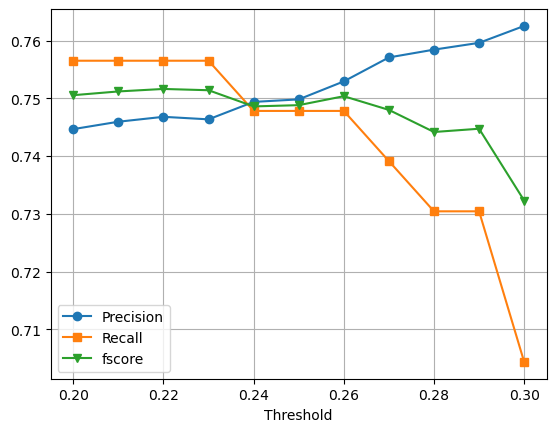

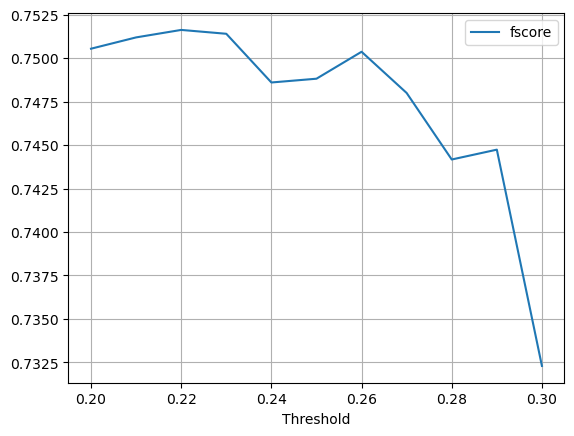

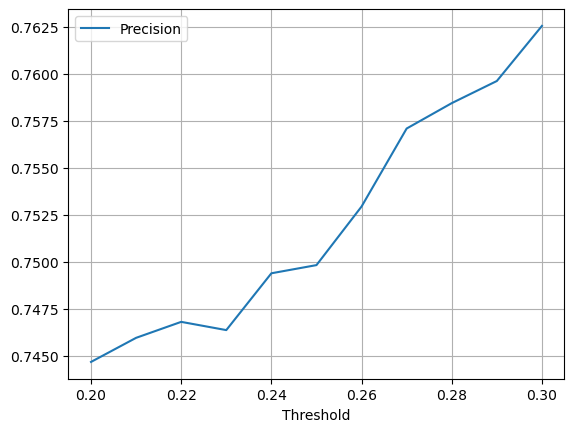

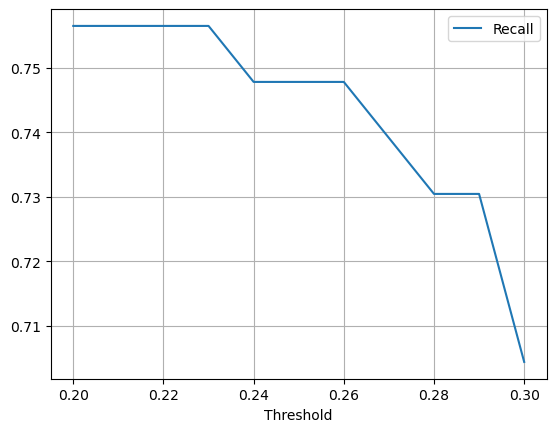

In [16]:
fig_pre_re_f(list, pre,re,fscores)
fig_fscore(list,fscores)
fig_precision(list, pre)
fig_recall(list, re)

テストデータに対する異常度算出

In [17]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
# テストデータ
testdata = '210921_0032'
testdata_path = '../data/wav/'+testdata+'.wav'
label_data_file = '../data/fixed_label/-2109220600.csv'

model_path = '../trainedmodel/alltraindata/sslautoencoder.hd5'

In [18]:
anomary_scores, notburied_anomary_scores, abnorm_thr = SemiSLAutoEncoder.predict(testdata_path, model_path, xbox=1.5, xdiff=0.26)

Model: "alltraindata_NormalSound.hdf5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.89it/s]


decoded_imgs.shape: (4883, 128, 32, 3)
data.shape: (4883, 128, 32, 3)
anomary_scores.shape: (4883,)
閾値：0.0014233207330107689
self.train_mean:-40.23991012573242
self.train_std:11.048879623413086
57496[sec]


100%|███████████████████████████████████████████████████████████████████████████| 57496/57496 [06:30<00:00, 147.05it/s]


file_basename:210921_0032
全testデータ数: 57496
mean:-40.23991012573242
std:11.048879623413086
test_base: (128, 32)
test_shape (57496, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 57496/57496 [00:48<00:00, 1180.71it/s]


hdfへの変換が完了したため./data_output/npy_files/test/を削除します
./data_output/npy_files/test/削除完了
label: 210921_0032
dataset[210921_0032_files].shape:(57496, 128, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 57496/57496 [00:07<00:00, 7542.39it/s]


data_value.shape: (57496, 128, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 57496/57496 [00:00<00:00, 81322.70it/s]


225


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:14<00:00, 15.29it/s]


In [19]:
anomary_scores_200ms = result_to_200ms(anomary_scores, duration) 
notburied_anomary_scores_200ms = result_to_200ms(notburied_anomary_scores, duration) 

テストデータの正解ラベルを読み込む

In [20]:
testlabel_data_df=pd.read_csv(label_data_file, skiprows=4, usecols=[0, 1], header=None)  # fileをデータフレームに出力
display(testlabel_data_df)
testlabel_data_array = testlabel_data_df.iloc[:, 1].values

C:\Users\arakawa eito\anaconda3\envs\env2_tf-gpu24\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1
0,44.3,0
1,44.3,0
2,44.3,0
3,44.6,0
4,44.6,0
...,...,...
287480,46.0,0
287481,46.0,0
287482,45.9,0
287483,45.9,0


In [21]:
# 騒音データと音声データの長さが違うので，正解ラベルの配列と異常度の配列の長さをそろえる必要がある
if len(testlabel_data_array)<=len(anomary_scores_200ms): 
    anomary_scores_200ms = anomary_scores_200ms[:len(testlabel_data_array)]
    notburied_anomary_scores_200ms = notburied_anomary_scores_200ms[:len(testlabel_data_array)]
else:
    testlabel_data_array = testlabel_data_array[:len(anomary_scores_200ms)]

評価値算出

test_array: [0 0 0 ... 0 0 0]
test:         label
0           0
1           0
2           0
3           0
4           0
...       ...
287475      0
287476      0
287477      0
287478      0
287479      0

[287480 rows x 1 columns]
[255248  15759  16473]
[255248  32232]
0.005574572831392288
適合率：11.214836
再現率：100.000000
適合率：11.274961
再現率：100.000000
適合率：11.346788
再現率：100.000000
適合率：11.415937
再現率：100.000000
適合率：11.453470
再現率：100.000000
適合率：11.521428
再現率：100.000000
適合率：11.600142
再現率：100.000000
適合率：11.697129
再現率：99.206349
適合率：11.796825
再現率：99.206349
適合率：11.886356
再現率：99.206349
適合率：11.982268
再現率：99.206349
適合率：12.079610
再現率：99.206349
適合率：12.193247
再現率：99.206349
適合率：12.287741
再現率：99.206349
適合率：12.373892
再現率：99.206349
適合率：12.435789
再現率：99.206349
適合率：12.542061
再現率：99.206349
適合率：12.693118
再現率：99.206349
適合率：12.796283
再現率：99.206349
適合率：12.935963
再現率：99.206349
適合率：13.086556
再現率：99.206349
適合率：13.220766
再現率：99.206349
適合率：13.365845
再現率：99.206349
適合率：13.553916
再現率：99.206349
適合率：13.701051
再現率：99.206349
適合

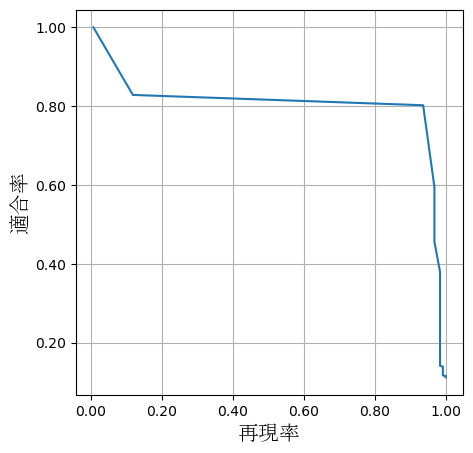

In [22]:
from validate import validate

df = pd.DataFrame(data=testlabel_data_array, columns=['label'])
auc = fig_PR(df, anomary_scores_200ms, 50)

test_array: [0 0 0 ... 0 0 0]
test:         label
0           0
1           0
2           0
3           0
4           0
...       ...
287475      0
287476      0
287477      0
287478      0
287479      0

[287480 rows x 1 columns]
[255248  15759  16473]
[255248  32232]
0.005574572831392288
適合率：11.211910
再現率：100.000000
適合率：23.395920
再現率：97.619048
適合率：23.756741
再現率：97.619048
適合率：24.166737
再現率：97.619048
適合率：24.561981
再現率：97.619048
適合率：24.928331
再現率：97.619048
適合率：25.365545
再現率：97.619048
適合率：25.818519
再現率：97.619048
適合率：26.224287
再現率：97.619048
適合率：26.581861
再現率：97.619048
適合率：27.076739
再現率：97.619048
適合率：27.573747
再現率：97.619048
適合率：28.086310
再現率：97.619048
適合率：28.572658
再現率：97.619048
適合率：29.138941
再現率：97.619048
適合率：29.671479
再現率：97.619048
適合率：30.258570
再現率：97.619048
適合率：30.893094
再現率：97.619048
適合率：31.521253
再現率：97.619048
適合率：32.029246
再現率：97.619048
適合率：32.692817
再現率：97.619048
適合率：33.310487
再現率：97.619048
適合率：33.920204
再現率：97.619048
適合率：34.682762
再現率：97.619048
適合率：35.656427
再現率：97.619048
適合率：36.5

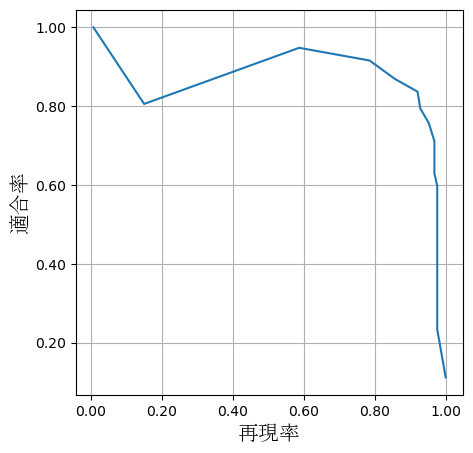

In [23]:
df = pd.DataFrame(data=testlabel_data_array, columns=['label'])
notburied_auc = fig_PR(df, notburied_anomary_scores_200ms, 50)

In [24]:
df = pd.DataFrame(data=testlabel_data_array, columns=['label'])
print('差分画像を使わない異常音判別結果')
validate(df, anomary_scores_200ms, abnorm_thr)
print(f'AUC:{auc}')

print('差分画像を使った異常音判別結果')
validate(df, notburied_anomary_scores_200ms, abnorm_thr)
print(f'AUC:{notburied_auc}')

差分画像を使わない異常音判別結果
適合率：78.158527
再現率：93.650794
AUC:0.7990693597591576
差分画像を使った異常音判別結果
適合率：81.463415
再現率：92.857143
AUC:0.8601557306925873


グラフ描画

In [25]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# 0.2秒単位の配列を1秒単位の正解ラベルに変換する
anomary_scores_sec_array = label_to_sec(anomary_scores_200ms)
notburied_anomary_scores_sec_array = label_to_sec(notburied_anomary_scores_200ms)
label_sec_array = label_to_sec(testlabel_data_array)

time_index = pd.date_range(start='2022-09-21 06:00:00', end='2022-09-21 22:00:00', freq='S')
time_index = time_index[:len(anomary_scores_sec_array)]

graphnum = -(-len(time_index)//3600)
# plt.rcParams['font.size']=18
figure, axes = plt.subplots(graphnum, 1, figsize=(35, 300))
for i in range(graphnum):

    axes[i].plot(date2num(time_index), (notburied_anomary_scores_sec_array), label="異常度")
    axes[i].fill_between(date2num(time_index), label_sec_array, color='red', alpha=0.5, label="異常ラベル")
    
    axes[i].set_xlabel('時刻', fontname="MS Mincho", fontsize=40)
    axes[i].set_ylabel('異常度', fontname="MS Mincho", fontsize=40)
    axes[i].xaxis.set_tick_params(labelsize = 35)
    axes[i].yaxis.set_tick_params(labelsize = 35)

    axes[i].legend(loc='lower center', bbox_to_anchor=(.5, 1.), ncol=2, prop={'family':"MS Mincho", 'size':35})

#     axes[i].set_xlabel('Time')
#     axes[i].set_ylabel('Abnormality')

    axes[i].set_ylim(abnorm_thr, 0.003)
    if i<(graphnum-1):
        axes[i].set_xlim(
            date2num(time_index[3600*i]), date2num(time_index[3600*(i+1)]))
    else:
        axes[i].set_xlim(date2num(time_index[3600*i]), date2num(time_index[-1]))
        
    axes[i].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    #5分おきにラベル
    Minute1=mdates.MinuteLocator(range(60),5)   
    axes[i].xaxis.set_major_locator(Minute1)